In [1]:
import numpy as np
import tensorflow as tf
import pyprind
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

##### loading glove embeddings as dictionary

In [2]:
def loadGloveModel(gloveFile):
    print "Loading Glove Model"
    pbar = pyprind.ProgBar(400000)
    f = open(gloveFile,'rb')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
        pbar.update()
    print "Done.",len(model)," words loaded!"
    return model

In [3]:
glove_file_name = "/home/kuldeep.singh/clarity_social_media_analysis/imdb_movie_data_project/glove/glove.6B.300d.txt"
glove_model = loadGloveModel(glove_file_name)

Loading Glove Model


0% [##############################] 100% | ETA: 00:00:00

Done. 400000  words loaded!



Total time elapsed: 00:00:35


##### loading imdb movie review data

In [4]:
df = pd.read_csv("/home/kuldeep.singh/clarity_social_media_analysis/imdb_movie_data_project/movie_data.csv")
df.head()

,review,sentiment
0,Usually I love Lesbian movies even when they a...,0.0
1,Prix de Beauté was made on the cusp of the cha...,1.0
2,This lasted several years despite the late hou...,1.0
3,This is 2009 and this way underrated gem has l...,1.0
4,John Waters has given us a genuinely enjoyable...,1.0


In [1]:
# function for preprocessing the movie reviews
def preprocess_text(text):
    text = re.sub("<[^>]*>", "", text)
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
    text = re.sub(strip_special_chars, " ", text.lower())
    text = re.sub("  ", " ", text)
    return text.strip()

In [6]:
df.review = df.review.apply(preprocess_text)

In [7]:
df.review[0]

'usually i love lesbian movies even when they are not very good i m biased i guess but this one is just the pits yes the scenery and the buildings are beautiful and there is a brief but beautiful erotic interlude but otherwise this movie is just a complete waste of time annamarie alternates between sulking and getting high stoned passing out on whatever drug or booze is handy and ella inexplicably puts up with this abominable behavior through the entire movie at no time are we given any insight into why this is so or even why annamarie is so depressed and withdrawn if there had at least been some kind of closure in the potentially romantic we don t even know relationship between the two there might have been some kind of satisfaction but although annamarie at one point asks ella why do you love me ella doesn t even acknowledge this it s never really clear whether this is anything more than an ill behaved lesbian on a boring road trip with a straight woman even the interactions between 

In [2]:
# defining max number of features to be extracted from count vectorizer
MAX_FEATURES = 2000

In [11]:
count = CountVectorizer(max_features=MAX_FEATURES)
docs = np.array(df.review)
bag = count.fit_transform(docs)

word2index_map = count.vocabulary_

In [12]:
type(glove_model.keys()[1]), type(word2index_map.keys()[1])

(str, unicode)

In [13]:
wordVectors = glove_model.values()
glove_model.keys()[399999], wordVectors[-1]

('sunda', array([  2.53770000e-01,  -2.77290000e-01,  -3.70360000e-01,
         -2.48790000e-01,   1.03050000e+00,  -8.03160000e-01,
          3.72680000e-01,   1.62870000e-01,  -2.27360000e-01,
          9.25530000e-02,  -1.06840000e-01,   8.18610000e-01,
         -2.76340000e-01,  -3.77100000e-01,   2.92330000e-01,
          1.35780000e-01,  -1.21440000e-01,   1.13000000e-01,
          1.42080000e-01,  -3.21240000e-02,   7.37820000e-01,
         -2.47010000e-01,   1.56340000e-01,   1.47730000e-01,
         -1.06590000e-01,  -8.56000000e-02,  -5.97600000e-01,
         -4.45970000e-01,   3.69810000e-02,   1.04570000e-01,
          2.47820000e-01,   1.03020000e+00,   4.06550000e-02,
          7.48950000e-02,   8.01150000e-01,  -1.64490000e-01,
          5.78510000e-02,   2.19920000e-01,   2.37920000e-01,
          3.68330000e-01,  -6.48590000e-02,   4.05760000e-02,
         -3.03270000e-01,  -7.08010000e-01,   6.42880000e-01,
         -2.87490000e-01,  -1.98730000e-02,   2.13390000e-02,

In [3]:
# keeping only those words which are present in Glove Model dictionary
# updating the word2index_map for which glove_model has vectors
updated_word2index_map = {}
for key, index in word2index_map.iteritems():
    if str(key) in glove_model.keys():
        updated_word2index_map[key] = index
len(updated_word2index_map)

NameError: name 'word2index_map' is not defined

In [15]:
# defining final vocabulary list to be used
UPDATED_VOCABULORY = updated_word2index_map.keys()
UPDATED_VOCABULORY.append("PAD")

In [16]:
# preparing final glove model for upadted vocabulary
UPDATED_GLOVE_MODEL = {}
for word in UPDATED_VOCABULORY:
    if word is "PAD":
        UPDATED_GLOVE_MODEL[word] = np.array([0]*glove_model["basketball"].shape[0], dtype=np.float64)
    else:
        UPDATED_GLOVE_MODEL[word] = glove_model[word]

len(UPDATED_GLOVE_MODEL)

2000

In [17]:
# # adding embedding for "PAD" token
# UPDATED_GLOVE_MODEL["PAD"] = np.array([10000]*300, dtype=np.float64)

In [18]:
wordVectors = UPDATED_GLOVE_MODEL.values()
print type(wordVectors)
print type(wordVectors[0])
print type(wordVectors[0][0])

<type 'list'>
<type 'numpy.ndarray'>
<type 'numpy.float64'>


In [19]:
# creating final word2index_map and index2word_map using final glove model
EMBEDDING_MATRIX = []
UPDATED_WORD2INDEX_MAP = {}
UPDATED_INDEX2WORD_MAP = {}

for i, word in enumerate(UPDATED_VOCABULORY):
    UPDATED_WORD2INDEX_MAP[word] = i
    UPDATED_INDEX2WORD_MAP[i] = word
    EMBEDDING_MATRIX.append(UPDATED_GLOVE_MODEL[word])

In [46]:
EMBEDDING_MATRIX = np.array(EMBEDDING_MATRIX, dtype=np.float32)

##### using 20000 reviews for the project

In [20]:
# preparing the input list of indices according to word embeddings 
data = []
pbar = pyprind.ProgBar(len(df.review[:20000]))
for review in df.review[:20000]:
    temp_data = []
    for word in review.lower().split():
        if word in UPDATED_VOCABULORY:
            temp_data.append(UPDATED_WORD2INDEX_MAP[word])
    data.append(temp_data)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:26


20000


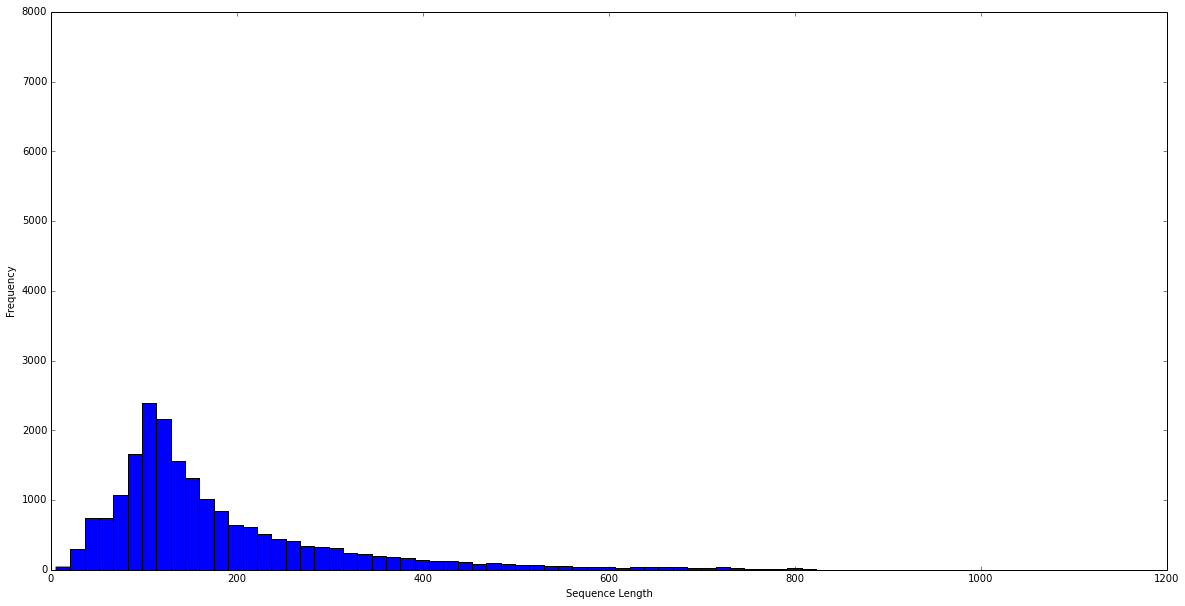

In [22]:
# plotting the length of sequences
lenList = []
for d in data:
    counter = len(d)
    lenList.append(counter)
print len(lenList)

#print lenList[:10]
plt.figure(figsize=(20,10))
plt.hist(lenList, 100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [23]:
labels = df.sentiment[:20000]
labels_one_hot = []
for i in range(len(labels)):
    label = int(labels[i])
    one_hot = [0.0]*2
    one_hot[label] = 1.0
    labels_one_hot.append(one_hot)

In [24]:
# function to generate batch 
def generate_batch(batch_size, data_x, data_y):
    instance_indices = list(range(len(data_x)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    x = [data_x[i] for i in batch]
    y = [data_y[i] for i in batch]
    return x, y

In [25]:
# function used for tensorboard
def variable_summaries(var):
    with tf.name_scope("summaries"):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope("stddev"):
            stddev= tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar("stddev", stddev)

### preparing tensorflow model

In [26]:
num_lstm_layers = 2
num_classes = 2
batch_size = 64
embedding_dimension = 300
hidden_layer_size = 128
time_steps = 300
vocabulary_size = len(UPDATED_VOCABULORY)

LOG_DIR = "/home/kuldeep.singh/books/deep learning /tensorflow_tutorials/logs/imdb_tensorflow_glove"

In [30]:
# padding
for i in range(len(data)):
    if len(data[i]) < 300:
        data[i].extend([len(UPDATED_WORD2INDEX_MAP) - 1]*(300 - len(data[i])))
    else:
        data[i] = data[i][:300]

In [31]:
train_x = data[:10000]
train_y = labels_one_hot[:10000]

test_x = data[10000:15000]
test_y = labels_one_hot[10000:15000]

validation_x = data[15000:20000]
validation_y = labels_one_hot[15000:20000]

In [47]:
_inputs = tf.placeholder(tf.int32, shape=[None, time_steps])
_labels = tf.placeholder(tf.float32, shape=[None, num_classes])

embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_dimension])
_keep_prob = tf.placeholder(tf.float32)

In [48]:
# if PRE_TRAINED:
embeddings = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_dimension]), trainable=False)

embedding_init = embeddings.assign(embedding_placeholder)
embed = tf.nn.embedding_lookup(EMBEDDING_MATRIX, _inputs)


In [49]:
def lstm_cell(hidden_layer_size):
    single_lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    single_lstm_cell = tf.contrib.rnn.DropoutWrapper(single_lstm_cell,  output_keep_prob = _keep_prob)
    return single_lstm_cell

In [50]:
with tf.variable_scope("lstm"):
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    cell = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell(hidden_layer_size) for _ in range(num_lstm_layers)],
                                       state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(cell, embed, dtype=tf.float32)
#     outputs, states = tf.nn.dynamic_rnn(lstm_cell, embed, dtype=tf.float32)

weights = {
    "linear_layer": tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean=0, stddev=0.01))
}

biases = {
    "linear_layer": tf.Variable(tf.truncated_normal([num_classes], mean=0, stddev=0.01))
}

In [51]:
final_output = tf.matmul(states[num_lstm_layers-1][1], weights["linear_layer"]) + biases["linear_layer"]

with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=final_output, labels=_labels))
    tf.summary.scalar("cross_entropy", cross_entropy)

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=final_output, labels=_labels))

with tf.name_scope("train_step"):
    train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)

with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(tf.argmax(final_output, 1), tf.argmax(_labels, 1))
    accuracy = (tf.reduce_mean(tf.cast(correct_predictions, tf.float32)))*100
    tf.summary.scalar("accuracy", accuracy)
    
merged = tf.summary.merge_all()

In [53]:
with tf.Session() as sess:
    
    train_writer = tf.summary.FileWriter(LOG_DIR + "/train", graph=tf.get_default_graph())
    validation_writer = tf.summary.FileWriter(LOG_DIR + "/test", graph=tf.get_default_graph())
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(5000):
        x_batch, y_batch = generate_batch(batch_size, train_x, train_y)
        
        summary, _ = sess.run([merged, train_step], feed_dict={_inputs: x_batch, _labels: y_batch,
                                                              _keep_prob: 0.75})
        train_writer.add_summary(summary, i)
        
        if i%100 == 0:
            acc, train_loss =  sess.run([accuracy, cross_entropy], feed_dict=
                                        {_inputs: x_batch, _labels: y_batch,
                                        _keep_prob: 0.75})
            
            print "Iteration: " + str(i) +", Minibatch loss: {:.6f}".format(train_loss)\
            + ", Training Accuracy: {:.5f}".format(acc)
        
        if i%10:
            x_val, y_val = generate_batch(batch_size, validation_x, validation_y)
            summary, validation_acc = sess.run([merged, accuracy], 
                                            feed_dict={
                                                _inputs:x_val, _labels:y_val,
                                                _keep_prob: 1.0
                                            })
            validation_writer.add_summary(summary, i)
        
    for test_batch in range(5):
        x_test, y_test = generate_batch(batch_size, test_x,test_y)
        batch_acc, _ = sess.run([accuracy, train_step], feed_dict={
            _inputs:x_test, _labels:y_test, _keep_prob: 1.0
        })
        print("Test batch accuracy %d: %.5f" % (test_batch, batch_acc))


Iteration: 0, Minibatch loss: 0.692777, Training Accuracy: 54.68750
Iteration: 100, Minibatch loss: 0.693716, Training Accuracy: 43.75000
Iteration: 200, Minibatch loss: 0.680003, Training Accuracy: 64.06250
Iteration: 300, Minibatch loss: 0.647529, Training Accuracy: 64.06250
Iteration: 400, Minibatch loss: 0.682140, Training Accuracy: 62.50000
Iteration: 500, Minibatch loss: 0.682808, Training Accuracy: 54.68750
Iteration: 600, Minibatch loss: 0.671875, Training Accuracy: 60.93750
Iteration: 700, Minibatch loss: 0.686757, Training Accuracy: 56.25000
Iteration: 800, Minibatch loss: 0.667344, Training Accuracy: 60.93750
Iteration: 900, Minibatch loss: 0.496791, Training Accuracy: 76.56250
Iteration: 1000, Minibatch loss: 0.609121, Training Accuracy: 67.18750
Iteration: 1100, Minibatch loss: 0.658843, Training Accuracy: 60.93750
Iteration: 1200, Minibatch loss: 0.530011, Training Accuracy: 75.00000
Iteration: 1300, Minibatch loss: 0.671328, Training Accuracy: 60.93750
Iteration: 1400, M